This notebook is usefull if the compiled version of the module does not work on your machine.<br>
Here you can try it if you have Cython on your distribution.

# Source (to import first)

In [1]:
%load_ext Cython

This is the source code of the module :

In [2]:
%%cython

#cython: language_level=3, boundscheck=False

#
#  SVBM
#


from sklearn.cluster import KMeans

from scipy.special import digamma, gammaln
cimport scipy.special.cython_special

#from math import log, exp
from libc.math cimport log, exp

import matplotlib.pyplot as plt


import numpy as np
cimport numpy as np

DTYPE = np.float
ctypedef np.float_t DTYPE_t
        

cdef class SVBM(object):
    
    # Public variable
    cdef public net, results
    
    
    #
    # Init : Create the dictionary to store results
    def __init__(self, net):
        self.net = net
        
        self.results = {}
        
        
        
    #
    # _init_tau : Initialize tau with a K-means
    cdef np.ndarray _init_tau(self, unsigned int Q):
        #Shortcut
        cdef unsigned int N = self.net.N
        cdef np.ndarray X = self.net.X
        
        # K-means
        kmeans = KMeans(n_clusters=Q).fit(X)
        
        # Building tau : tau[i][q] = 1 if i is within class q
        cdef int i, q
        cdef np.ndarray[DTYPE_t, ndim=2] tau = np.zeros([N, Q], dtype=DTYPE)
        for i, q in enumerate(kmeans.labels_):
            tau[i][q] = 1
            
        return tau
      
        
        
        
    #
    # _iter_theta : Iterate theta with E-step : n, eta, zeta
    def _iter_theta(self, int Q, np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        #Shortcut
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] X = self.net.X
        cdef int N = len(tau)
        
        # Init
        cdef np.ndarray[DTYPE_t, ndim=1, mode="c"] n = np.zeros(Q, dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] eta = np.zeros([Q,Q], dtype=DTYPE)
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta = np.zeros([Q,Q], dtype=DTYPE)
        
        # Cython
        cdef int q, i, l, j
        cdef float s_n, s_eta, s_zeta 
        cdef bint sym = self.net.symmetric # Handle symetric matrix
        
        # Building n, eta and zeta
        for q in range(Q):                            
            # N
            s_n = 0.5
            for i in range(N):
                s_n += tau[i,q]
            n[q] = s_n

            # Eta, Zeta
            for l in range(Q):
                s_eta, s_zeta = 0.5, 0.5 # Default value
                for j in range(N):
                    for i in range(N):
                        if (q == l and j <= i and sym): break
                        if i == j: continue

                        s_eta += X[i,j]*tau[i,q]*tau[j,l]
                        s_zeta += (1-X[i,j])*tau[i,q]*tau[j,l]

                eta[q,l] = s_eta
                zeta[q,l] = s_zeta 
        
        return n, eta, zeta
    
    
    
    
    #
    # _iter_tau : Iterate tau with M-step : tau
    # Return also the delta = |tau_old - tau_new|
    def _iter_tau(self,
                  np.ndarray[DTYPE_t, ndim=1, mode="c"] n,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] eta,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta,\
                  np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        
        #Shortcut
        cdef int Q = len(n)
        cdef int N = self.net.N
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] X = self.net.X
        
        # Computing digamma... (saving a lot of time)
        cdef np.ndarray[DTYPE_t, ndim=2, mode="c"] dig_sum = digamma(eta + zeta)
        cdef float dig_n_sum = digamma(n.sum())
        zeta, eta, n = digamma(zeta), digamma(eta), digamma(n) # Same variables to save memory
        
        # Init cython
        cdef int i, q, j, l
        cdef float delta = 0
        cdef float a
        
        # Building tau
        cdef np.ndarray[DTYPE_t, ndim=2] tau_new = np.zeros([N, Q], dtype=DTYPE)
        for i in range(N):
            for q in range(Q):
                p = exp(n[q]-dig_n_sum) # init tau[i][q]
                for j in range(N):
                    if (i==j): continue
                    for l in range(Q):
                        a = zeta[q,l] - dig_sum[q,l] + X[i,j]*(eta[q,l] - zeta[q,l])
                        a *= tau[j,l]
                        p *= exp(a)
                tau_new[i,q] = p
        
        # Normalizing
        row_sums = tau_new.sum(axis=1)
        tau_new = tau_new / row_sums[:, np.newaxis]            
        
        delta = np.linalg.norm(tau - tau_new)
        return tau_new, delta

    
    
    
    #
    # _lover_bound_aprox : Give the lILvb (to use after convergence)
    cdef float _lower_bound_aprox(self,\
                                  np.ndarray[DTYPE_t, ndim=1, mode="c"] N,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] eta,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] zeta,\
                                  np.ndarray[DTYPE_t, ndim=2, mode="c"] tau):
        # Shortcut
        cdef int n = tau.shape[0]
        cdef int Q = tau.shape[1]
        
        # Init
        cdef float s = 0
        cdef int l, q, i
        
        # First log
        s += gammaln(Q*0.5) - gammaln(sum(N)) - Q*gammaln(0.5)
        for q in range(Q):
            s += gammaln(N[q])

       # Single sum
        s += (Q*(Q+1)*0.5)*(gammaln(1) - 2*gammaln(0.5))
        for l in range(Q):
            for q in range(l+1):
                s += gammaln(eta[q][l]) + gammaln(zeta[q][l]) - gammaln(eta[q][l]*zeta[q][l])

        # Double sum
        for i in range(n):
            for q in range(Q):
                s -= 0 if tau[i][q] == 0  else tau[i][q]*log(tau[i][q])

        return s
    
        
    
    
    #
    # _run_Q : Run the SVBM for a single Q and stored the result
    def _run_Q(self, Q):
        
        # Return cache if exists
        if Q in self.results:
            return self.results[Q]

        
        print("Computing for " + str(Q) + " classes...")
        
        #Shortcut
        N, X = self.net.N, self.net.X
         
        # Init
        print("Initialisation via K-means...")
        tau = self._init_tau(Q)
        
        # Iterating
        print("Iterating Variational EM...", end="\r")
        for iterr in range(300):
            
            # Esperance
            n, eta, zeta = self._iter_theta(Q, tau)

            # Maximisation
            tau, delta = self._iter_tau(n, eta, zeta, tau)

            # Lower bound
            lower_bound = self._lower_bound_aprox(n, eta, zeta, tau)
            
            # Show
            print("Iteration n°" + str(iterr+1) + " :"\
                  + " Lower bound -> " + str(lower_bound)\
                  + " | Delta -> " + str(delta), end="\r")
            
            # Break condition
            if (299 <= iterr):
                print("\nNo convergence !")
                conv = False
                break
            if (delta < 10E-4):
                print("\nEM has converged")
                conv = True
                break
        
        # Computing params mean
        Z = self._compute_Z(tau)
        pi = eta / (eta + zeta)
        alpha = np.bincount(Z)/len(Z)
        
        # Cache result and return it
        self.results[Q] = {
            "Z" : Z,
            "pi" : pi,
            "alpha" : alpha,
            "lower_bound" : lower_bound,
            "tau" : tau,
            "n" : n,
            "eta" : eta,
            "zeta" : zeta,
        }
        return self.results[Q]
    
    
    #
    # 
    def _compute_Z(self, tau):            
        res = []
        for t  in tau:
            res.append(t.argmax())
        return res
  




#
#  Public function -> Interface
#
    
    #
    # run : run the SVBM for a range of Q
    def run(self, Q_min = 2, Q_max = None):
        Q_max = Q_min if Q_max is None else Q_max
        
        for Q in range(Q_min, Q_max + 1):
            self._run_Q(Q)
            
            
            
            
    #
    # get : return the result of the SVBM for q classes
    def get(self, q = None):
        return self.results if q is None else self._run_Q(q)
       
        
        
        
    #
    # plot_lower_bound : plot the lILvb for all Q stored
    def plot_lower_bound(self):
        # Building point
        X, Y = [], []
        for Q, r in self.get().items():
            X.append(Q)
            Y.append(r["lower_bound"])
        
        # Plotting point
        plt.figure()
        plt.title("Lower bound")
        plt.ylabel("ILvb")
        plt.xlabel("Q")
        plt.scatter(X, Y)
        
        #Plot max
        X, Y = np.array(X), np.array(Y)
        Q_max = X[Y.argmax()]
        plt.plot([Q_max,Q_max], [Y.min(),Y.max()], color="red")
        
        
        
        
    #
    # plot_matrix : plot the matrix of adjency of the network for q classes
    def plot_matrix(self, q = None):
        # Shortcut
        X = np.array(self.net.X)
        n = len(X)
        Z = np.array(self.get(q)["Z"]) if q is not None else np.zeros(n)

        #Init
        plt.figure()
        plt.title("Adjacency matrix with "+str(q)+" classes")
        plt.xlabel("Individual")
        plt.ylabel("Individual")
        
        # Plot border
        plt.plot([0,0], [0,n], color="red")
        plt.plot([0,n], [0,0], color="red")

        # Assign an new index for each individual following classes
        person_to_id = {} # Dict (old_index, new_index)
        for q in np.unique(Z):
            
            a = np.where(Z == q)[0] # Get original index of class q
            a = dict(zip(a, range(len(person_to_id), len(person_to_id) + len(a)))) # Assign new index
            person_to_id.update(a) # Add the new index in the dict

            # Plot border line for class q
            plt.plot([len(person_to_id), len(person_to_id)], [0,n], color="red")
            plt.plot([0,n], [len(person_to_id), len(person_to_id)], color="red")

        # Apply the new index to connextion in the adjency matrix X
        a = np.vectorize(lambda person : person_to_id[person])(np.where(X == True)) 
        
        # Plot the links
        plt.scatter(a[0], a[1], marker="X", s=1)

        
        
        
        
        
        


#
#  Network classes
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Raw_SBM(object):
    def __init__(self, X):
        # Preproc for cython
        X = np.array(X)
        X = X.astype(np.float)
        X = X.copy(order='C')
        
        # Adjency matrix
        self.X = np.array(X, dtype = np.float)
        
        # Properties
        self.N = len(X)
        self.Q = None
        self.symmetric = np.allclose(self.X, self.X.T, atol = 1e-8)
        
    def plot(self):
        a = np.where(self.X > 0)
        plt.figure()
        plt.title("Adjacency matrix")
        plt.xlabel("Individual")
        plt.ylabel("Individual")
        plt.scatter(a[0], a[1], marker="X", s=1)
        return self
        
        
        
class HofWig_SBM(Raw_SBM):
    def __init__(self, n, Q, alpha = None, p_epsilon = 0.1, p_lambda = 0.9):
        
        # Generate an alpha
        if alpha is None:
            a = np.random.uniform(size=Q)
            alpha = a/a.sum()
        if len(alpha) != Q: raise ValueError("Alpha has not the same length as Q")

        # Defines class
        Z = np.zeros(n, dtype=np.uint)
        i = 0
        for q, n_q in enumerate(np.random.multinomial(n, alpha)):
            for j in range(n_q):
                Z[i] = q
                i += 1

        # Probability matrix of connection between classes
        pi = self._get_pi(Q, p_lambda, p_epsilon)

        # Matrix of connections
        X = np.zeros((n,n))
        for i in range(n):
            q_i = Z[i]
            for j in range(i):
                q_j = Z[j]
                bound = np.random.binomial(1, pi[q_i][q_j])
                X[i][j] = bound
                X[j][i] = bound
        
        super(HofWig_SBM, self).__init__(X)

        self.Z = Z
        self.Q = Q
        
        
    def _get_pi(self, Q, p_lambda, p_epsilon):
        return np.zeros((Q,Q)) + p_epsilon + np.diag([p_lambda - p_epsilon]*Q)
         
        
    def compare(self, Z):
        if self.Z is None:
            raise ValueError("This network does not have a Z variable. SVBM can't compare !")
            
        return pd.DataFrame([list(Z), list(self.Z)]).transpose().groupby([0,1]).size()
    
    
    
class Hub_SBM(HofWig_SBM):
    # Just update the pi matrix to add an hub class
    def _get_pi(self, Q, p_lambda, p_epsilon):
        pi = super(Hub_SBM, self)._get_pi(Q, p_lambda, p_epsilon)
        pi[Q-1] = [p_lambda]*Q
        return pi
        

class CSV_SBM(Raw_SBM):
    def __init__(self, path, header = True):
        raw = np.loadtxt(path, delimiter = ",")
        X = raw[1:,:] if header else raw
        super(CSV_SBM, self).__init__(X)




# You can work here

In [3]:
%matplotlib notebook
import numpy as np

### HofWig

<IPython.core.display.Javascript object>


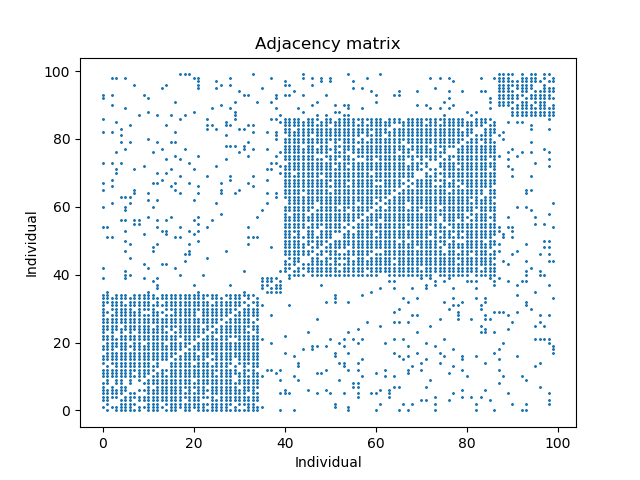

In [4]:
net = HofWig_SBM(100,4)
net.plot()

In [5]:
s = SVBM(net,)
s.run(2,6)

Computing for 2 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -13939785.0 | Delta -> 4.642809657613166e-27
EM has converged
Computing for 3 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -5237057.0 | Delta -> 2.1929779384788663e-23
EM has converged
Computing for 4 classes...
Initialisation via K-means...
Iteration n°1 : Lower bound -> -4746179.5 | Delta -> 6.223158877105561e-09
EM has converged
Computing for 5 classes...
Initialisation via K-means...
Iteration n°8 : Lower bound -> -4746187.0 | Delta -> 1.0592941454556914e-11
EM has converged
Computing for 6 classes...
Initialisation via K-means...
Iteration n°50 : Lower bound -> -4746178.0 | Delta -> 9.34836789383553e-054
EM has converged


<IPython.core.display.Javascript object>


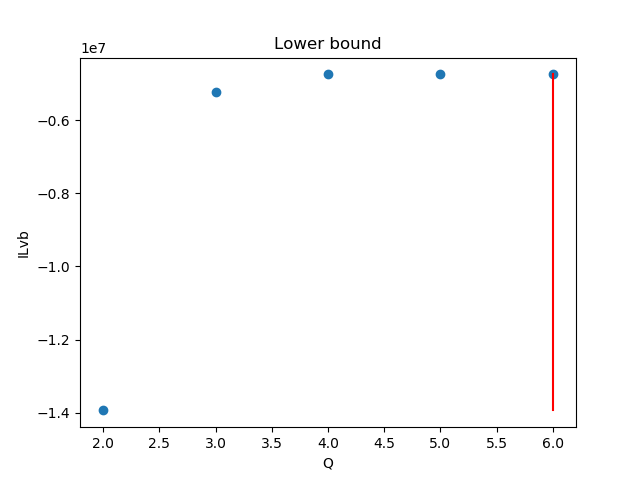

<IPython.core.display.Javascript object>


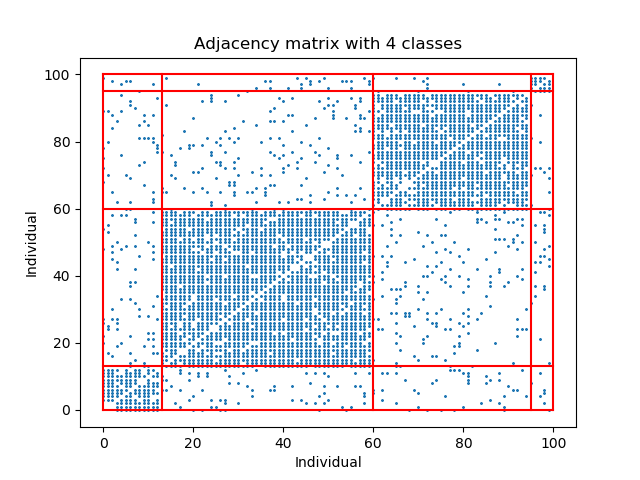

array([[ 0.84177215,  0.11519608,  0.09758772,  0.11363636],
       [ 0.11519608,  0.91081331,  0.10358445,  0.10381356],
       [ 0.09758772,  0.10358445,  0.89513423,  0.07670455],
       [ 0.11363636,  0.10381356,  0.07670455,  0.95454545]])

In [6]:
s.plot_lower_bound()
s.plot_matrix(4)
s.get(4)["pi"]

### Enron

<IPython.core.display.Javascript object>


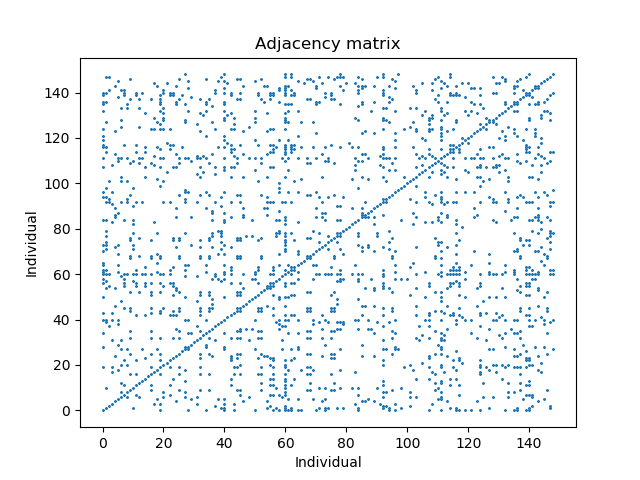

In [7]:
# Loading Enron data (reduced matrix)
X = np.load("enron_network.npy")
net_enron = Raw_SBM(X)
net_enron.plot()

In [8]:
# Building SVBM class (stored all the results)
s = SVBM(net_enron)

In [9]:
s.run(2,15)

Computing for 2 classes...
Initialisation via K-means...
Iteration n°26 : Lower bound -> -87129592.0 | Delta -> 0.0006093502743169665
EM has converged
Computing for 3 classes...
Initialisation via K-means...
Iteration n°15 : Lower bound -> -36617072.0 | Delta -> 0.0006224183016456664
EM has converged
Computing for 4 classes...
Initialisation via K-means...
Iteration n°16 : Lower bound -> -19320034.0 | Delta -> 0.0009383959113620222
EM has converged
Computing for 5 classes...
Initialisation via K-means...
Iteration n°9 : Lower bound -> -10702562.0 | Delta -> 0.0006882589077576995
EM has converged
Computing for 6 classes...
Initialisation via K-means...
Iteration n°40 : Lower bound -> -3879657.25 | Delta -> 0.0008331223507411778
EM has converged
Computing for 7 classes...
Initialisation via K-means...
Iteration n°24 : Lower bound -> -2124481.5 | Delta -> 0.00093626236775889996
EM has converged
Computing for 8 classes...
Initialisation via K-means...
Iteration n°11 : Lower bound -> -40339

<IPython.core.display.Javascript object>


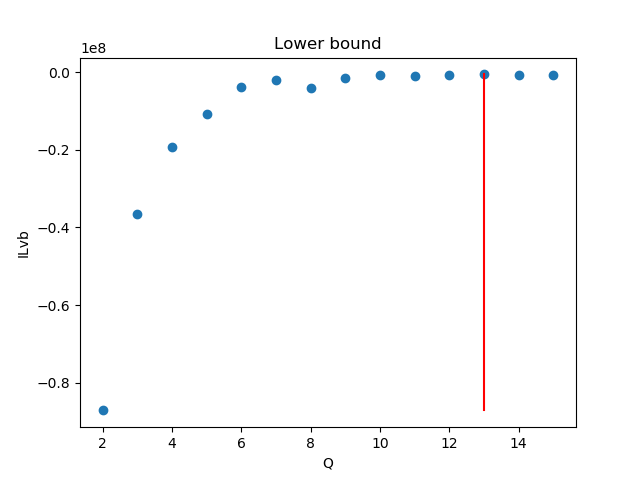

<IPython.core.display.Javascript object>


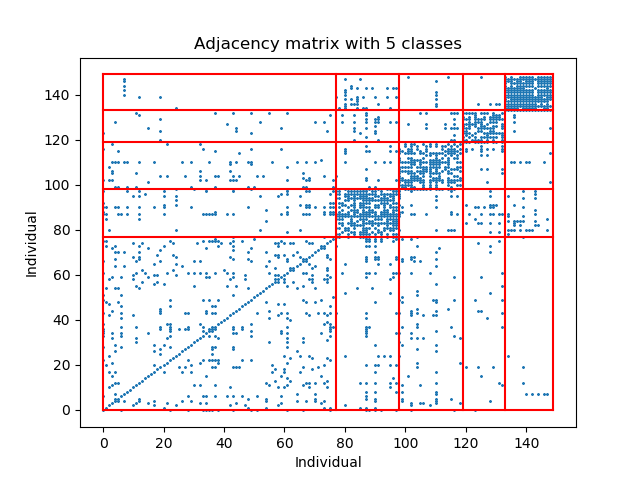

In [10]:
s.plot_lower_bound()
s.plot_matrix(5)